# Surface Energy Budget in 6 hourly single column data
This looks at the hottest day of the year using 6 hourly data i.e. can we predict hottest day of year based on max input flux.

In [1]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v, g
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import calendar
from datetime import timedelta
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Calculate Drag coefficient from LH and other parameters in dataset
# def get_drag_coef(flux_lhe, temp_surf, temp_diseqb, rh, p_surf, evap_prefactor, wind_speed, sigma):
#     # Could also compute from sensible heat as a sanity check
#     temp_a = temp_surf - temp_diseqb
#     p_a = p_surf*sigma
#     rho = get_density(temp_a, p_a)
#     sphum_a = rh * sphum_sat(temp_a, p_a)
#     return flux_lhe / (evap_prefactor * L_v * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a))

def get_drag_coef(flux_t, temp_surf, temp_diseqb, wind_speed, sigma, p_surf=None, density=None):
    # From sensible heat as no evap fraction which can be 0.
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return flux_t / (c_p * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa))

def get_temp_rad(lwdn_sfc, opd):
    # Returns radiative temperature, T_r, such that LW_down = sigma T_r^4 (1 - e^{-opd})
    emission_factor = 1 - np.exp(-opd)
    return (lwdn_sfc / emission_factor / Stefan_Boltzmann)**0.25

def get_water_column_depth(sphum, pressure):
    # sphum in kg/kg
    # pressure in Pa
    # Both should have first value at p=0 and last at p=p_surface
    # returns water column depth in kg/m^2
    return scipy.integrate.trapz(sphum, pressure, axis=0) / g

def get_opd_from_water_depth(water_col_depth, mass_abs_coef=0.05):
    # water col depth is mass of water vapour in column [kg/m^3]
    # mass absorption coefficient is in units of m^2/kg
    return water_col_depth * mass_abs_coef

In [3]:
def shift_time(ds):
    # Make 1st time year 1, day 1, month 1
    # Assume `ds` is your dataset
    n_times = ds.time.size

    # Create new time array starting at year 1, day 1, 12:00 using 360_day calendar
    new_time = [cftime.Datetime360Day(1, 1, 1, 12) + timedelta(days=i) for i in range(n_times)]

    # Assign new time coordinate
    ds['time'] = ('time', new_time)
    return ds

In [409]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'flux_lhe', 'flux_t']
var_keep = {'gray': var_keep + ['swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 'swdn_toa'],
            'soc': var_keep + ['soc_toa_sw_down', 'soc_surf_flux_sw_down', 'soc_surf_flux_sw',
                               'soc_surf_flux_lw_down', 'soc_surf_flux_lw', 'soc_coszen']}

def rename_ds_soc(ds):
    # Rename socrates dataset to match names of gray
    ds['lwup_sfc'] = ds.soc_surf_flux_lw + ds.soc_surf_flux_lw_down
    return ds.rename({'soc_surf_flux_sw': 'swdn_sfc', 'soc_surf_flux_lw_down': 'lwdn_sfc', 'soc_toa_sw_down': 'swdn_toa'})

# # DEFAULT experiment
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/column/'
# exp_name = ['evap=0']
exp_name = {'gray': 'base', 'soc': 'socrates'}


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name['gray'])
if 'column_nml' in namelist:
    p_surface_approx = namelist['column_nml']['reference_sea_level_press']/100
else:
    p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

if 'column_nml' in namelist:
    # In single column, wind is constant and has default value of 5m/s
    try:
        w_atm_const = isca_tools.load_namelist(exp_dir+exp_name['gray'])['column_init_cond_nml']['surface_wind']
    except KeyError:
        w_atm_const = 5
else:
    w_atm_const = None
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name['gray'])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1
try:
    land_h_capacity_prefactor = isca_tools.load_namelist(exp_dir+exp_name['gray'])['mixed_layer_nml']['land_h_capacity_prefactor']
except KeyError:
    land_h_capacity_prefactor = 1
albedo = {key: isca_tools.load_namelist(exp_dir+exp_name[key])['mixed_layer_nml']['albedo_value'] for key in exp_name}
opd_sw_gray = isca_tools.load_namelist(exp_dir+exp_name['gray'])['two_stream_gray_rad_nml']['atm_abs']

n_exp = len(exp_name)
lat_range = slice(0, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
pressure_ft = 500
mass_abs_coef_water = 0.05          # approx mass abosrption coefficient for water (m^2/kg) in longwave according to chatGPT
# use_time_start = cftime.Datetime360Day(10, 1, 1)   # Year 10, January 1st
use_time_start = cftime.Datetime360Day(11, 1, 1)   # Year 1, January 1st
use_time_end = cftime.Datetime360Day(9000, 12, 30)  # Year 9000, December 30th (basically infinity)
ds_base = {}
pbar = tqdm(total=n_exp)
for i, key in enumerate(var_keep):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[key], decode_times=True).isel(lon=0, drop=True)
    ds_use = ds_use[var_keep[key]]
    if key == 'soc':
        ds_use = rename_ds_soc(ds_use)
    ds_use = ds_use.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range)
    ds_use['water_depth'] = ds_use['ps']*0 + get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull*100)
    # ds_use['water_depth'] = get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull.values*100)
    ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp.isel(pfull=0)**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp.isel(pfull=0)
    ds_use['rh'] = ds_use.sphum.isel(pfull=0) / sphum_sat(ds_use.temp.isel(pfull=0), ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_use['flux_sfc_dn_net'] = ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc - ds_use.flux_lhe - ds_use.flux_t
    # Compute deviation from lowest level and radiative temperature given surface optical depth
    ds_use['temp_diseqb_rad_gray'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, opd_lw_gray(ds_use.lat))
    ds_use['opd_water'] = get_opd_from_water_depth(ds_use.water_depth, mass_abs_coef_water)
    ds_use['temp_diseqb_rad_water'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, ds_use.opd_water)
    ds_use['mse'] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).isel(pfull=0)
    if 'drag_q' not in ds_use:
        # Need to change this if evap_prefactor changes with latitude
        ds_use['drag_q'] = get_drag_coef(ds_use.flux_t, ds_use.t_surf, ds_use.temp_diseqb, w_atm_const, sigma_near_surf, ds_use.ps)
    if 'w_atm' not in ds_use:
        ds_use['w_atm'] = ds_use['drag_q']*0+w_atm_const        # keep dimensions is useful for functions later

    ds_use = shift_time(ds_use)       # shift so first is year 1, month 1, day 1
    ds_base[key] = ds_use.load()      # only keep after spin up
    pbar.update(1)
ds_base['soc']['opd_sw'] = ds_base['soc'].soc_coszen * np.log(ds_base['soc'].swdn_toa/(ds_base['soc'].soc_surf_flux_sw_down+1e-10))
xr.testing.assert_identical(ds_base['gray'].time, ds_base['soc'].time)      # ensure times are the same
mixed_layer_depth = {'ocean': namelist['mixed_layer_nml']['depth']}
mixed_layer_depth['land'] = namelist['mixed_layer_nml']['land_h_capacity_prefactor'] * mixed_layer_depth['ocean']
ind_surf = 0
ind_ft = 1
pressure_ft_actual = float(ds_base['gray'].pfull[ind_ft]*100)
p_surface = float(ds_base['gray'].pfull[ind_surf]*100)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 181 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [509]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_lat = [np.floor(ds_base['gray'].lat[0]), np.ceil(ds_base['gray'].lat[-1])]
ax_lims_time = [0, 360]

leg_info = {'handlelength': 1, 'labelspacing': 0.2, 'columnspacing': 0.9, 'handletextpad': 0.5}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

In [411]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name['gray'].replace('_6_hours', ''), 'land.nc')
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]  # get the latitude coordinates of land
lat_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[0]
lat_land_min = (lat_land.min() + lat_ocean.max()) / 2           # show land in plots as average between ocean and land extrema

# Add heat capacity to dataset
for key in ds_base:
    ds_base[key]['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth['land'] *
                                                    (ds_base['gray'].lat > lat_land_min) + mixed_layer_depth['ocean'] *
                                                      (ds_base['gray'].lat < lat_land_min))

## Get Day and Night Datasets
Here, I select the dataset for night (9PM - 3AM) and day (9AM - 3PM) on each day; and average over all years to get a dataset with one value for each day of the year. I then smooth this over 20 days.

In [412]:
def get_smooth_array(ds, window=20, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_annual_mean_at_hour(ds, hour=12):
    # Returns dataset wth only a given hour at each day, and then for each day average over all years of dataset.
    # Returned dataset only has 360 time values (one for each year)
    if hour not in ds.time.dt.hour:
        raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_use = ds.where(ds.time.dt.hour == hour, drop=True)
    return ds_use.groupby("time.dayofyear").mean(dim="time")


smooth_sz = 20   # smooth over 20 days
ds = {key: get_smooth_array(get_annual_mean_at_hour(ds_base[key]), smooth_sz) for key in ds_base}
ds['diff'] = ds['gray'] - ds['soc']
exp_label = {'gray': 'Gray', 'soc': 'SOCRATES', 'diff': 'Gray-SOC'}
color_exp = {'gray': default_colors[0], 'soc': default_colors[1]}

In [421]:
# Load in gray dataset which included dynamics
ds_dyn = isca_tools.load_dataset(exp_dir.replace('/column', '/base'), decode_times=True).isel(lon=0, drop=True)
ds_dyn = ds_dyn[var_keep['gray']]
ds_dyn = ds_dyn.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range).sel(pfull=[np.inf, pressure_ft], method='nearest')
ds_dyn['mse'] = moist_static_energy(ds_dyn.temp, ds_dyn.sphum, ds_dyn.height).isel(pfull=0)
ds_dyn = ds_dyn[['t_surf', 'mse']]
ds_dyn = shift_time(ds_dyn)
ds_dyn = get_smooth_array(get_annual_mean_at_hour(ds_dyn), smooth_sz).load()

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [422]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Surface Temperature
The surface temperature distributions are compared below. The crosses indicate the hottest day of the year, it occurs later and at the lowest land latitude for the SOCRATES simulation.

It is not surprising that the SOCRATES simulation is almost uniformly colder, as it has a larger surface albedo.

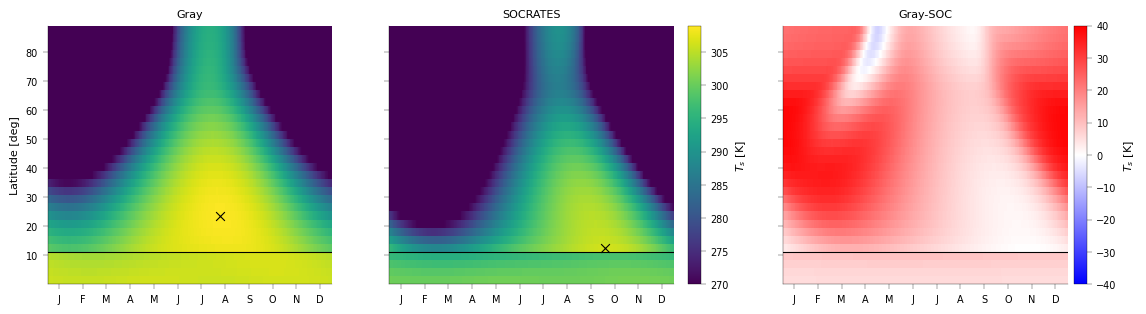

In [660]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].t_surf.transpose(), vmin=270, vmax=309)
    var = get_extrema_coordinates(ds[key].t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].t_surf.transpose(), vmin=-40, vmax=40, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

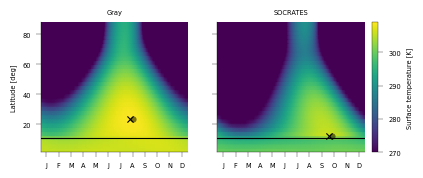

In [665]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for i, ds_use in enumerate([ds['gray'], ds['soc']]):
    im = ax[i].pcolormesh(ds_use.dayofyear, ds_use.lat, ds_use.t_surf.transpose(), vmin=270, vmax=309, shading='gouraud')
    var = get_extrema_coordinates(ds_use.t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=20)
    var = get_extrema_coordinates(ds_use.mse, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='o', s=20, alpha=0.5, linewidths=0)
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Surface temperature [K]')
ax[0].set_title(exp_label['gray'])
ax[1].set_title(exp_label['soc'])
isca_tools.plot.update_fontsize(fig)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()
isca_tools.savefig(fig, 'surface_temp')

### Seasonal Cycle
From the above, it is clear that the seasonal cycle has a stronger seasonal amplitude over land. This is emphasized below.

The explanation for this is that there is a water vapour feedback in optical depth for SOCRATES, whereas optical depth is constant year round for Gray. I.e. in summer, more water vapour in atmosphere so larger optical depth and more downwelling longwave radiation at surface than if optical depth was constant. In winter see the opposite.

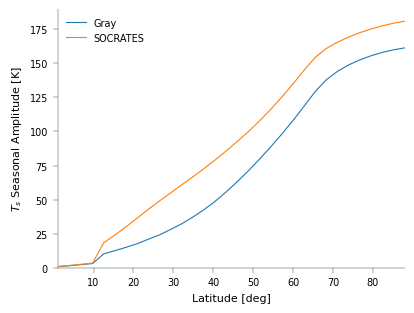

In [424]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for key in ['gray', 'soc']:
    ax.plot(ds[key].lat, ds[key].t_surf.max(dim='dayofyear')-ds[key].t_surf.min(dim='dayofyear'), color=color_exp[key], label=exp_label[key])
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$T_s$ Seasonal Amplitude [K]')
plt.show()

### Latitudinal variation in temperature
Below we see that on a given day, the temperature peaks at the lowest land latitude for SOCRATES, while for the gray case, the peak in temperature is at a higher latitude.

The two dates are the date of the hottest gray (solid) and SOCRATES (dotted) temperature.

An explanation for this may be that the gradient in optical depth is larger for the SOCRATES simulation.

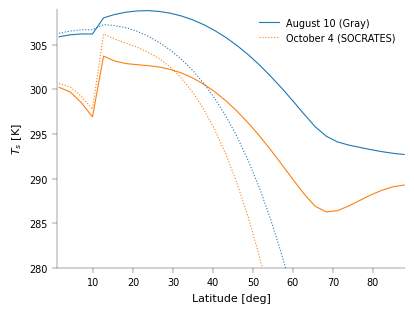

In [425]:
def get_month_day_from_ind(day_index):
    month = day_index // 30 + 1  # +1 for 1-based month
    day = day_index % 30 + 1     # +1 for 1-based day
    return month, day

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for key2 in ['gray', 'soc']:
    day_plot = get_extrema_coordinates(ds[key2].t_surf, 'max')['dayofyear']
    var = get_month_day_from_ind(day_plot)
    label_use = f'{calendar.month_name[var[0]]} {var[1]}'
    for key in ['gray', 'soc']:
        ax.plot(ds[key].lat, ds[key].t_surf.isel(dayofyear=day_plot), color=color_exp[key],
                linestyle=':' if key2=='soc' else '-', label=label_use + f" ({exp_label[key]})" if key==key2 else None)
ax.set_ylim(280, 309)
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$T_s$ [K]')
ax.set_xlim(ax_lims_lat)
plt.show()

## MSE
The MSE distribution is similar to the surface temperature. The peak in MSE (faint circles) is at the same latitude but slightly later in the year. This is due relative humidity having a phase delay compared to surface temperature.

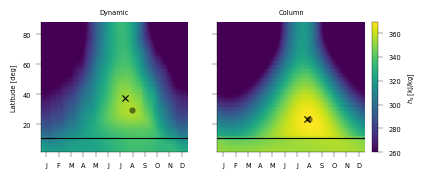

In [662]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for i, ds_use in enumerate([ds_dyn, ds['gray']]):
    im = ax[i].pcolormesh(ds_use.dayofyear, ds_use.lat, ds_use.mse.transpose(), vmin=260, vmax=369, shading='gouraud')
    var = get_extrema_coordinates(ds_use.t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=20)
    var = get_extrema_coordinates(ds_use.mse, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='o', s=20, alpha=0.5, linewidths=0)
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$h_s$ [kJ/kg]')
ax[0].set_title('Dynamic')
ax[1].set_title('Column')
isca_tools.plot.update_fontsize(fig)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()
# isca_tools.savefig(fig, 'mse')

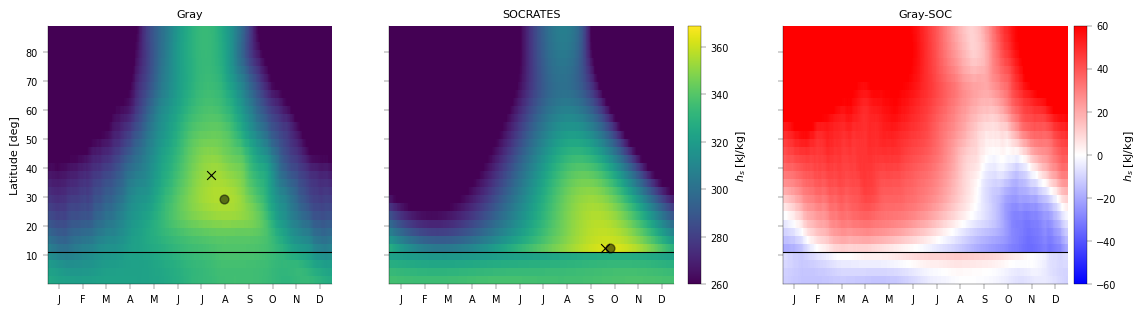

In [400]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].mse.transpose(), vmin=260, vmax=369)
    var = get_extrema_coordinates(ds[key].t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
    var = get_extrema_coordinates(ds[key].mse, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='o', s=40, alpha=0.5)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$h_s$ [kJ/kg]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].mse.transpose(), vmin=-60, vmax=60, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$h_s$ [kJ/kg]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Relative Humidity
Relative humidity seems to be generally larger in summer for the gray case at midlatitudes and further north. It is pretty similar over ocean and in subtropics around time of hottest day.

I think on average, the relative humidity is larger for SOCRATES (especially over ocean) is because it is colder and thus less rain as shown below. Note that the winter high latitude relative humidity does not really mean anything because the temperatures are so small, there is essentially no moisture in the atmosphere.

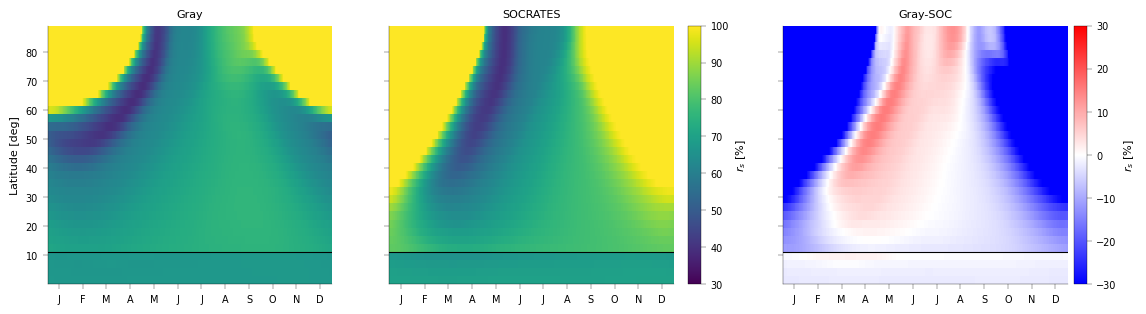

In [13]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].rh.transpose()*100, vmin=30, vmax=100)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].rh.transpose()*100, vmin=-30, vmax=30, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

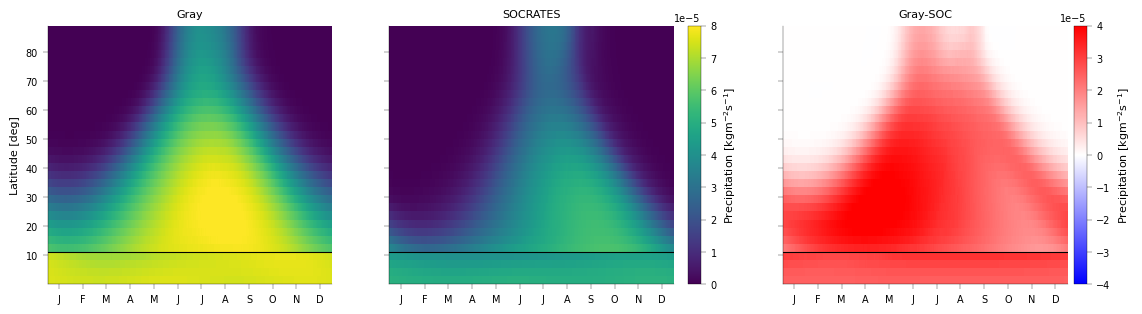

In [14]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].precipitation.transpose(), vmin=0, vmax=8e-5)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].precipitation.transpose(), cmap='bwr', vmin=-4e-5, vmax=4e-5)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

## Surface Energy Budget Parameters
Now we look at some other variables that go into the surface energy budget.
### Drag
The drag coefficient tends to be smaller ocean, by a significant fraction, with noticeable impact in the surface energy budget.

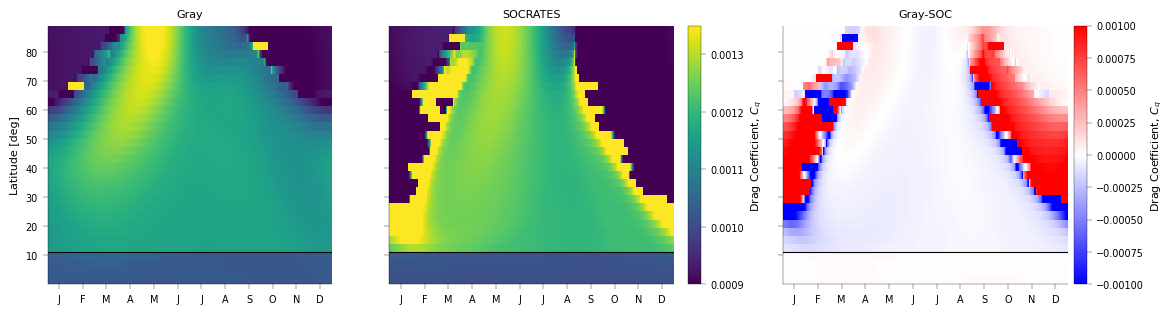

In [15]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].drag_q.transpose(), vmin=0.0009, vmax=0.00135)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Drag Coefficient, $C_q$')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].drag_q.transpose(), cmap='bwr', vmin=-0.001, vmax=0.001)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Drag Coefficient, $C_q$')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()


### Disequilibrium temperature,
This surface-air temperature difference, $T_{diseqb} = T_s - T_a$, is pretty similar for the two except it delayed more for SOCRATES. Again, this must be due to water vapour feedback. This is emphasized by the different hysteresis shape for a given latitude.

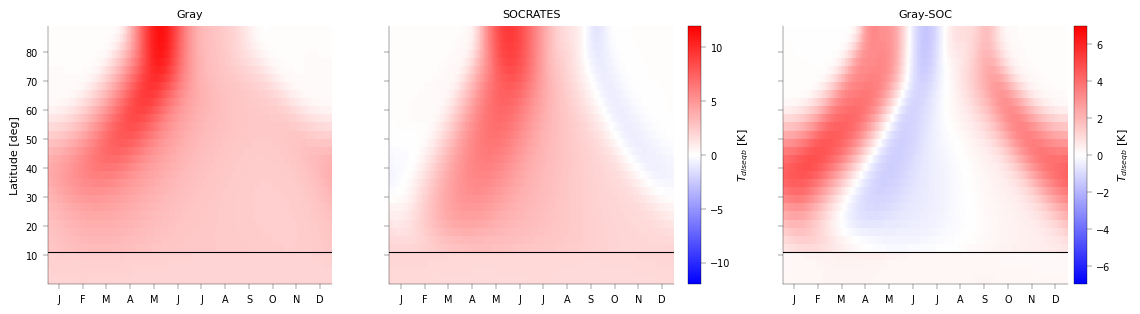

In [16]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb.transpose(), vmin=-12, vmax=12, cmap='bwr')
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].temp_diseqb.transpose(), cmap='bwr', vmin=-7, vmax=7)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

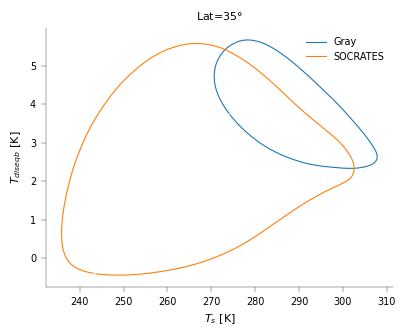

In [17]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
lat_plot_ind = 12
for key in ['gray', 'soc']:
    ax.plot(ds[key].t_surf.isel(lat=lat_plot_ind), ds[key].temp_diseqb.isel(lat=lat_plot_ind), label=exp_label[key], color=color_exp[key])
ax.set_xlabel('$T_s$ [K]')
ax.set_ylabel('$T_{diseqb}$ [K]')
ax.legend()
ax.set_title(f'Lat={ds["gray"].lat[lat_plot_ind].values:.0f}$\degree$')
plt.show()

### Optical Depth
The optical depth for the gray gas case is imposed in the simulation, and is constant in time.

For SOCRATES, there is no optical depth as a full radiative transfer is performed. However, if we assume little ozone effect, it is entirely determined by water vapour. Hence we can estimate it from the water column depth, $W = \int_0^{p_s} q/g dp$: $\tau = \kappa W$ where $\kappa$ is a mass absorption coefficient, which we estimate as 0.05 here. This then clearly is peaked in the hottest days, as shown below.

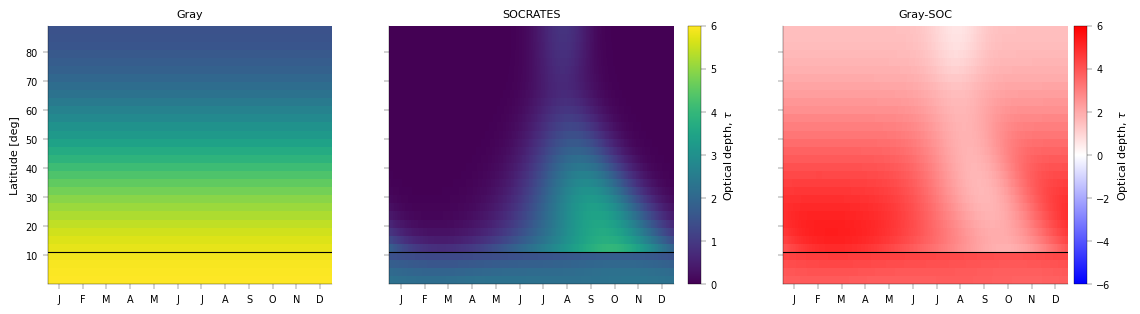

In [18]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, (ds[key].ps*0+opd_lw_gray(ds[key].lat)).transpose() if key=='gray'
    else ds[key].opd_water.transpose(), vmin=0, vmax=6)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, opd_lw_gray(ds[key].lat) - ds['soc'].opd_water.transpose(), cmap='bwr', vmin=-6, vmax=6)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Radiative Disequilibrium Temperature
The downward longwave radiation reaching the surface is given by $LW^{\downarrow} = \sigma T_r^4 (1-e^{-\tau})$. From this and the above equation for optical depth, we can then compute $T_r$. Below, we show the difference, $T_{diseqb,r}=T_a - T_r$, between the near-surface air and radiative temperature.

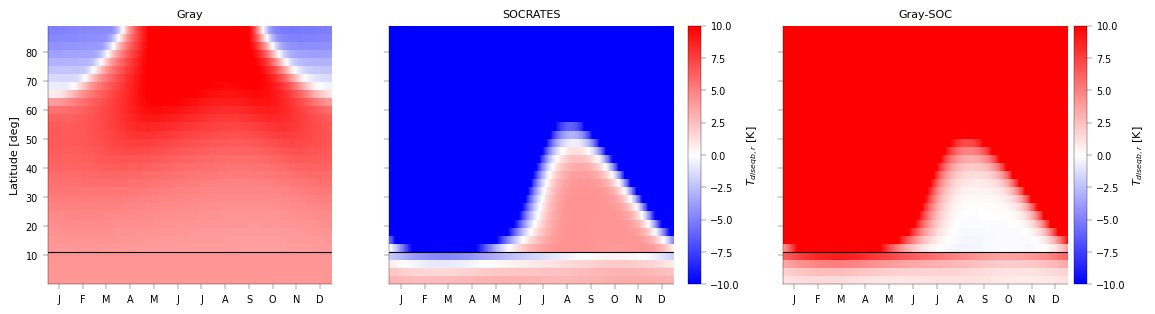

In [19]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb_rad_gray.transpose() if key=='gray'
    else ds[key].temp_diseqb_rad_water.transpose(), vmin=-10, vmax=10, cmap='bwr')
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb,r}$ [K]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, (ds['gray'].temp_diseqb_rad_gray - ds['soc'].temp_diseqb_rad_water).transpose(),
                      cmap='bwr', vmin=-10, vmax=10)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb,r}$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

## Surface Fluxes and estimates
Here we show the surface fluxes associated with the surface energy budget, as well as approximate values obtained using constant variables except for surface temperature. I.e. the variation due to just surface energy fluxes.

In [240]:
def get_land_median_var(ds, var):
    return float(ds[var].sel(lat=slice(lat_land_min, np.inf)).median())
const_params = {var: get_land_median_var(ds['gray'], var) for var in ['ps', 'drag_q', 'rh', 'temp_diseqb']}
const_params['w_atm'] = w_atm_const
const_params['temp_diseqb_rad'] = 5
const_params['rh'] = 0.75
const_params['temp_diseqb'] = 2.3
const_params

{'ps': 100000.0,
 'drag_q': 0.0011636314447969198,
 'rh': 0.75,
 'temp_diseqb': 2.3,
 'w_atm': 5,
 'temp_diseqb_rad': 5}

### Latent Heat
We see that the latent heat variation is predominantly due to $T_s$.

In [241]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

flux_temp_only = {
    'lhe': {key: get_latent_heat(ds[key].t_surf, const_params['temp_diseqb'], const_params['rh'], const_params['ps'],
                                 const_params['w_atm'], const_params['drag_q']) for key in ds}}

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


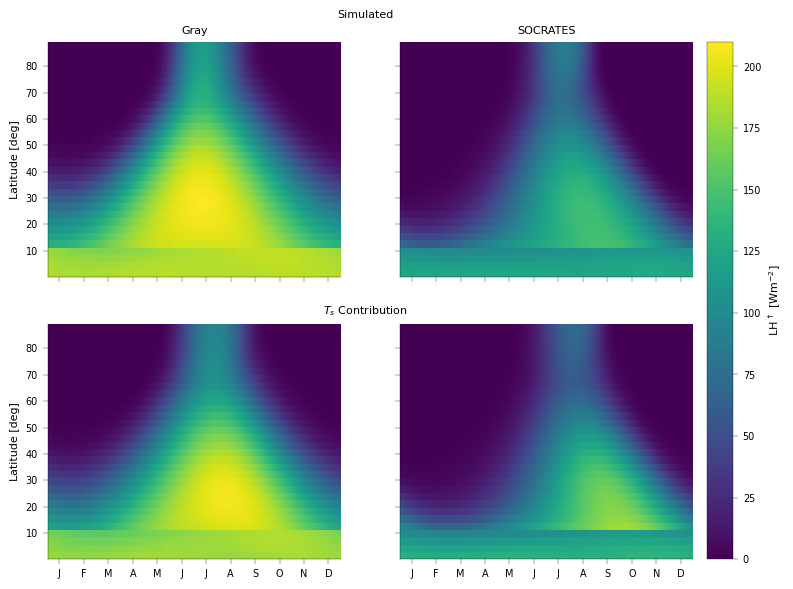

In [242]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i, key in enumerate(['gray', 'soc']):
    im = ax[0, i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].flux_lhe.transpose(), vmin=0, vmax=212)
    im = ax[1, i].pcolormesh(ds[key].dayofyear, ds[key].lat, flux_temp_only['lhe'][key].transpose(), vmin=0, vmax=210)
    ax[0, i].set_title(exp_label[key])
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='LH$^{\\uparrow}$ [Wm$^{-2}$]')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
fig.text(0.48, 0.92, 'Simulated', va='center', ha='center', fontsize=8)
fig.text(0.48, 0.48, '$T_s$ Contribution', va='center', ha='center', fontsize=8)
plt.show()

### Sensible Heat
Below we see that the sensible heat flux variation is almost entirely due to variation in $T_{diseqb}$, so we don't capture the high latitude trend with just $T_s$.

In [243]:
def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False,
                      rh=None):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf * (1 - sigma ** (-kappa)) + temp_diseqb * sigma ** (-kappa))

flux_temp_only['sh'] = {key: get_sensible_heat(ds[key].t_surf, const_params['temp_diseqb'], const_params['ps'],
                                               const_params['w_atm'], const_params['drag_q']) for key in ds}

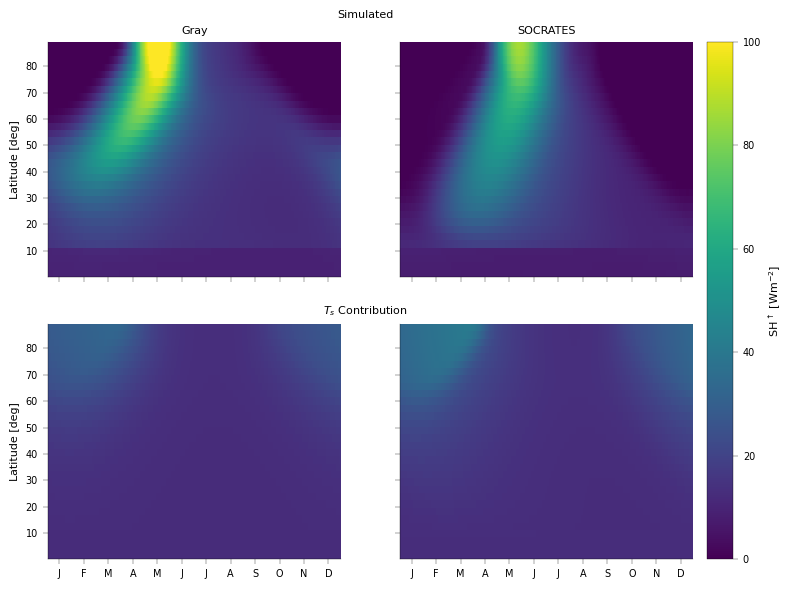

In [244]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i, key in enumerate(['gray', 'soc']):
    im = ax[0, i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].flux_t.transpose(), vmin=0, vmax=100)
    im = ax[1, i].pcolormesh(ds[key].dayofyear, ds[key].lat, flux_temp_only['sh'][key].transpose(), vmin=0, vmax=100)
    ax[0, i].set_title(exp_label[key])
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='SH$^{\\uparrow}$ [Wm$^{-2}$]')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
fig.text(0.48, 0.92, 'Simulated', va='center', ha='center', fontsize=8)
fig.text(0.48, 0.48, '$T_s$ Contribution', va='center', ha='center', fontsize=8)
plt.show()

### Longwave
#### Optical depth dependence on near-surface specific humidity
To estimate the surface temperature contribution to longwave radiation at the surface, we first need a relation between water column depth and specific humidity, so we can estimate the optical depth relation to surface temperature.

We do this below, and the constant of proportionality is related to the scale height of the atmosphere.

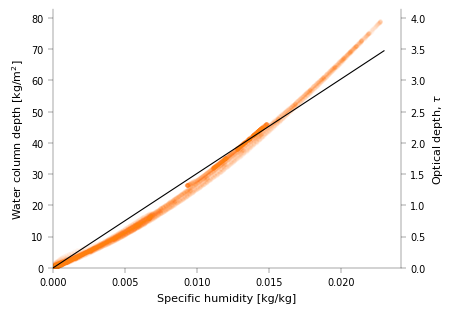

In [245]:
def get_opd_water_approx(temp_surf, temp_diseqb, rh, scale_height_const, mass_abs_coef_water=mass_abs_coef_water, p_surf=const_params['ps'],
                         sigma=sigma_near_surf):
    p_a = p_surf * sigma
    # scale_height_const is ratio of water_depth / sphum_near_surf, is related to scale height
    sphum = rh * sphum_sat(temp_surf + temp_diseqb, p_a)
    water_depth = sphum * scale_height_const
    return mass_abs_coef_water * water_depth

scale_height_const = np.linalg.lstsq(ds['soc'].sphum.isel(pfull=0).values.flatten()[:, np.newaxis], ds['soc'].water_depth.values.flatten(),
                                     rcond=None)[0][0]
opd_water_approx = {key: get_opd_water_approx(ds[key].t_surf, const_params['temp_diseqb'], const_params['rh'], scale_height_const)
                    for key in ['gray', 'soc']}

fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
ax.scatter(ds['soc'].sphum.isel(pfull=0), ds['soc'].water_depth, alpha=0.02, color=color_exp['soc'])
ax.plot(np.linspace(0, 0.023, 100), scale_height_const * np.linspace(0, 0.023, 100), color='k')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Water column depth [kg/m$^2$]')
ax.set_xlabel('Specific humidity [kg/kg]')

secax = ax.secondary_yaxis('right', functions=(lambda x: mass_abs_coef_water*x, lambda x: x/mass_abs_coef_water))
secax.set_ylabel('Optical depth, $\\tau$')

plt.show()

#### Empirical fit
Below we see there is an approximately exponential relationship between the amount of water in the column, and the longwave radiation reaching the surface.

We thus use this fit to estimate the longwave radiation from the surface temperature, disequilibrium temperature and near-surface relative humidity.

I initially thought as for the gray case that $LW = \sigma T_r^4 (1-e^{-\tau})$, and then say a disequilibrium temperature between the lowest level of atmosphere and radiative temperature stays approx constant throughout year.

However, it seems when water vapour feedback is permitted, the exponential relationship below is better i.e. $LW = A\tau^B$ for empirically found parameters $A$ and $B$.

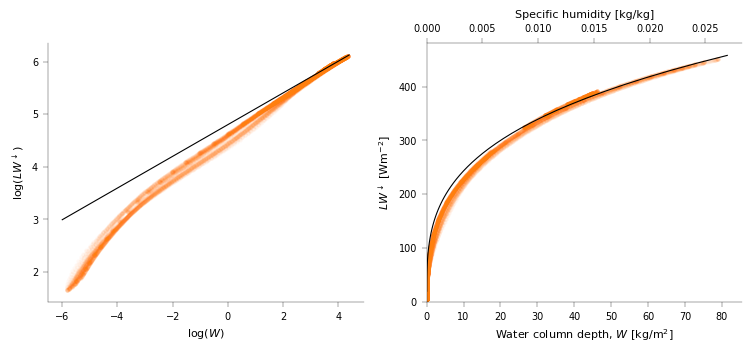

In [246]:
fig, ax = plt.subplots(1, 2)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
ax[0].scatter(np.log(ds['soc'].water_depth), np.log(ds['soc'].lwdn_sfc), alpha=0.02, color=color_exp['soc'])
use = ds['soc'].water_depth.values.flatten() > 30       # bias to hot days as that is our major concern here
lw_empirical_factors = np.polyfit(np.log(ds['soc'].water_depth.values.flatten()[use]), np.log(ds['soc'].lwdn_sfc.values.flatten()[use]), 1)
var = np.linspace(-6, 4.4, 100)
ax[0].plot(var, np.polyval(lw_empirical_factors, var), color='k')
lw_empirical_factors[1] = np.exp(lw_empirical_factors[1])           # take exponential so is a amplitude factor
ax[1].scatter(ds['soc'].water_depth, ds['soc'].lwdn_sfc, alpha=0.02, color=color_exp['soc'])
ax[1].plot(np.exp(var), lw_empirical_factors[1] * np.exp(var) ** lw_empirical_factors[0], color='k')
ax[0].set_ylabel('$\log(LW^{\\downarrow})$')
ax[1].set_ylabel('$\\tau_{sw}$')
ax[0].set_xlabel('$\log(W)$')
ax[1].set_ylabel('$LW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('Water column depth, $W$ [kg/m$^2$]')
ax[1].set_xlim(0, ax[1].get_xlim()[1])
ax[1].set_ylim(0, ax[1].get_ylim()[1])

secax = ax[1].secondary_xaxis('top', functions=(lambda x: x / scale_height_const, lambda x: x * scale_height_const))
secax.set_xlabel('Specific humidity [kg/kg]')
plt.show()

##### Approximate $T_s$ Dependence
The downward longwave radiation at the surface can now be well approximated by just the surface temperature as shown below.


In [247]:
def get_lwdn_sfc(temp_surf, temp_diseqb, temp_diseqb_rad=None, opd=None, scale_height_const=None, empirical_amp=None, empirical_power=None,
                 p_surf=const_params['ps'], sigma=sigma_near_surf):
    if opd is None and temp_diseqb_rad is None:
        p_a = p_surf * sigma
        water_depth = scale_height_const * sphum_sat(temp_surf - temp_diseqb, p_a)
        return empirical_amp * water_depth**empirical_power
    else:
        emission_factor = 1 - np.exp(-opd)
        temp_rad = temp_surf - temp_diseqb - temp_diseqb_rad
    return Stefan_Boltzmann * temp_rad**4 * emission_factor

flux_temp_only['lwdn_sfc'] = {'gray': get_lwdn_sfc(ds['gray'].t_surf, const_params['temp_diseqb'], const_params['temp_diseqb_rad'],
                                                   opd_lw_gray(ds['gray'].lat)),
                              'soc': get_lwdn_sfc(ds['soc'].t_surf, const_params['temp_diseqb'], scale_height_const=scale_height_const,
                                                  empirical_amp=lw_empirical_factors[1], empirical_power=lw_empirical_factors[0])}


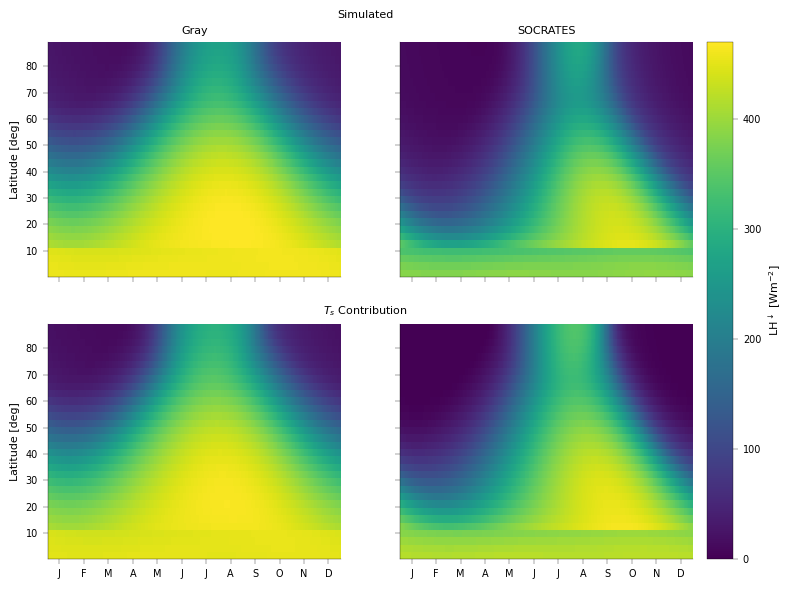

In [248]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['gray', 'soc']):
    im = ax[0, i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].lwdn_sfc.transpose(), vmin=0, vmax=470)
    im = ax[1, i].pcolormesh(ds[key].dayofyear, ds[key].lat, flux_temp_only['lwdn_sfc'][key].transpose(), vmin=0, vmax=470)
    ax[0, i].set_title(exp_label[key])
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='LH$^{\\downarrow}$ [Wm$^{-2}$]')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
fig.text(0.48, 0.92, 'Simulated', va='center', ha='center', fontsize=8)
fig.text(0.48, 0.48, '$T_s$ Contribution', va='center', ha='center', fontsize=8)
plt.show()


### Shortwave Radiation
#### Insolation
The incoming shortwave radiation at the top of the atmosphere, is slightly more for SOCRATES than the Gray case, as is shown below.

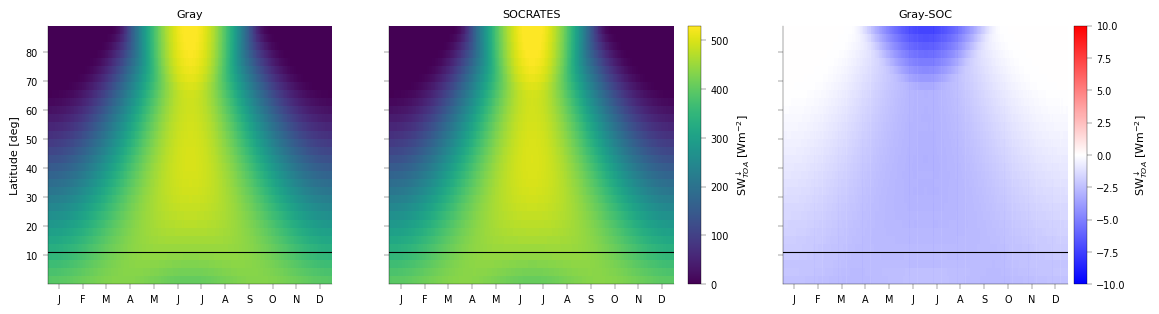

In [249]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].swdn_toa.transpose(), vmin=0, vmax=530)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='SW$^{\downarrow}_{TOA}$ [Wm$^{-2}$]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].swdn_toa.transpose(), cmap='bwr', vmin=-10, vmax=10)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='SW$^{\downarrow}_{TOA}$ [Wm$^{-2}$]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

#### Downward shortwave radiation at surface
The downward shortwave radiation at the surface is seasonally symmetric for the gray case, as atmospheric absorption is `0.2` throughout the year. For SOCRATES however, both ozone and water vapour interact with shortwave radiation. This means there is more shortwave radiation reaching the surface in spring than autumn because it is colder in autumn, so less water in atmosphere and more reaches the surface.

Also, the amount of stuff in the atmosphere decreases with latitude, so even though concentration of ozone is constant, actual amount decreases so get less absorption at higher latitudes. This is why in general in spring, the SOCRATES shortwave radiation is closer to the gray case at higher latitudes.

Over equatorial ocean, it is clearly less than the gray case. This reduced insolation at the equator might be why the hottest day is not at the equator  but in the subtropics.

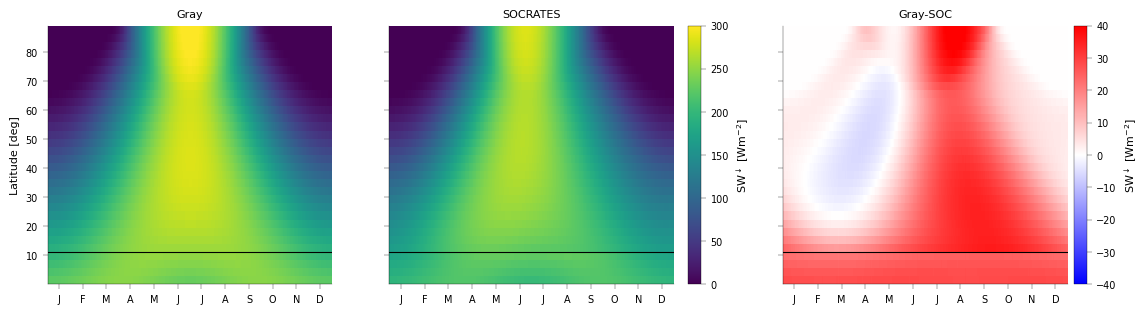

In [250]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].swdn_sfc.transpose(), vmin=0, vmax=300)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='SW$^{\downarrow}$ [Wm$^{-2}$]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].swdn_sfc.transpose(), cmap='bwr', vmin=-40, vmax=40)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='SW$^{\downarrow}$ [Wm$^{-2}$]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

#### Shortwave Optical Depth
I thought the seasonal aysymmetry may be because the shortwave optical depth increases with water depth, so more sunlight is absorbed in autumn vs spring, when there is more water in the atmosphere.

Below, we see that this is somewhat the case, although the relationship is much more complicated:
* It makes sense that a given increase in water column depth would cause a greater increase in optical depth for lower starting optical depth, as there is less competition for capturing photons with other molecules in the atmosphere.
* I am less sure about the hysteresis, but maybe when the zenith angle is smaller, more photons available so for the same amount of water, more sunlight is absorbed. I would have thought the $\mu=\cos(\theta_z)$ factor would take account of this, but maybe there is an approximation issue in averaging over the diurnal cycle - $\theta_z$ changes over course of a day.
* Don't know why with no water, optical depth appears to be zero. Would have though ozone would have a contribution.

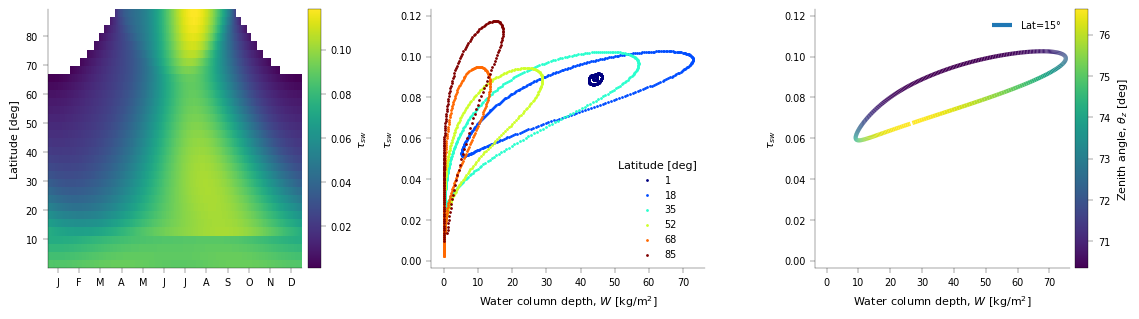

In [251]:
# ozone_file_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/depth=20/all_nh/lat_10/column/socrates/ozone.nc'
# ozone_mass_mixing = xr.open_dataset(ozone_file_path).isel(lon=0, drop=True).ozone.load()
lat_plot_ind = 5
fig, ax = plt.subplots(1, 3)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
im = ax[0].pcolormesh(ds[key].dayofyear, ds[key].lat, ds['soc'].opd_sw.transpose())
fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.05, pad=0.02, label='$\\tau_{sw}$')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')

cmap_use = [plt.get_cmap('jet')(i) for i in np.linspace(0, 1, 6)]
j=0
for i in range(0, ds['soc'].lat.size, 6):
    use = ds['soc'].swdn_toa.isel(lat=i) > 0
    ax[1].scatter(ds['soc'].water_depth.isel(lat=i).where(use), ds['soc'].opd_sw.isel(lat=i).where(use), color=cmap_use[j], s=1,
                  label=f"{use.lat.values:.0f}")
    j+=1
ax[1].legend(title='Latitude [deg]')
ax[1].set_xlabel('Water column depth, $W$ [kg/m$^2$]')
ax[1].set_ylabel('$\\tau_{sw}$')

ax[2].sharex(ax[1])
ax[2].sharey(ax[1])
im = isca_tools.plot.colored_line(ds['soc'].water_depth.isel(lat=lat_plot_ind), ds['soc'].opd_sw.isel(lat=lat_plot_ind),
                                  c=np.rad2deg(np.arccos(ds['soc'].soc_coszen.isel(lat=lat_plot_ind))), ax=ax[2], lw=3,
                                  label=f"Lat={ds['soc'].lat.isel(lat=lat_plot_ind):.0f}$\degree$")
fig.colorbar(im, ax=ax[2], orientation="vertical", fraction=0.05, pad=0.02, label='Zenith angle, $\\theta_z$ [deg]')
ax[2].set_xlabel('Water column depth, $W$ [kg/m$^2$]')
ax[2].set_ylabel('$\\tau_{sw}$')
ax[2].legend()
plt.subplots_adjust(wspace=0.4)
plt.show()

#### Empirical Fit
Below I empirically fit an exponential dependence of shortwave optical depth on water column depth, and thus using the previous scale height empirical parameter, we can also relate shortwave optical depth to near-surface specific humidity.

Text(0.5, 0, 'Specific humidity [kg/kg]')

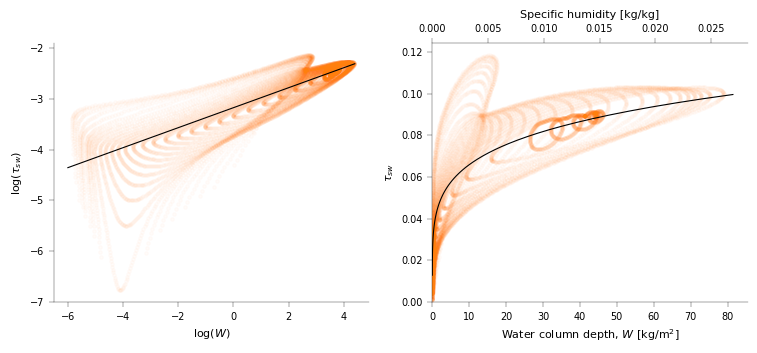

In [252]:
fig, ax = plt.subplots(1, 2)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
ax[0].scatter(np.log(ds['soc'].water_depth), np.log(ds['soc'].opd_sw), alpha=0.02, color=color_exp['soc'])
use = ds['soc'].opd_sw.values.flatten() > 0.01
opd_sw_empirical_factors = np.polyfit(np.log(ds['soc'].water_depth.values.flatten()[use]), np.log(ds['soc'].opd_sw.values.flatten()[use]), 1)
var = np.linspace(-6, 4.4, 100)
ax[0].plot(var, np.polyval(opd_sw_empirical_factors, var), color='k')
ax[1].scatter(ds['soc'].water_depth, ds['soc'].opd_sw, alpha=0.02, color=color_exp['soc'])
opd_sw_empirical_factors[1] = np.exp(opd_sw_empirical_factors[1])     # take exponential so is amplitude now
ax[1].plot(np.exp(var), opd_sw_empirical_factors[1] * np.exp(var) ** opd_sw_empirical_factors[0], color='k')
ax[0].set_ylabel('$\log(\\tau_{sw})$')
ax[1].set_ylabel('$\\tau_{sw}$')
ax[0].set_xlabel('$\log(W)$')
ax[1].set_xlabel('Water column depth, $W$ [kg/m$^2$]')
ax[1].set_xlim(0, ax[1].get_xlim()[1])
ax[1].set_ylim(0, ax[1].get_ylim()[1])

secax = ax[1].secondary_xaxis('top', functions=(lambda x: x / scale_height_const, lambda x: x * scale_height_const))
secax.set_xlabel('Specific humidity [kg/kg]')

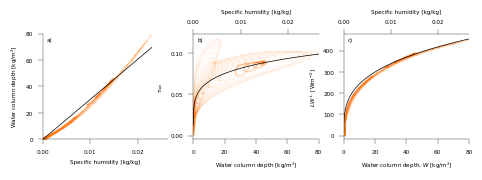

In [643]:
fig, ax = plt.subplots(1, 3)
isca_tools.plot.fig_resize(fig, width['two_col'])
ax[0].scatter(ds['soc'].sphum.isel(pfull=0), ds['soc'].water_depth, alpha=0.02, color=color_exp['soc'], s=0.2)
ax[0].plot(np.linspace(0, 0.023, 100), scale_height_const * np.linspace(0, 0.023, 100), color='k')
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[0].set_ylabel('Water column depth [kg/m$^2$]')
ax[0].set_xlabel('Specific humidity [kg/kg]')

var = np.linspace(-6, 4.4, 100)
ax[1].scatter(ds['soc'].water_depth, ds['soc'].opd_sw, alpha=0.02, color=color_exp['soc'], s=0.2)
ax[1].plot(np.exp(var), opd_sw_empirical_factors[1] * np.exp(var) ** opd_sw_empirical_factors[0], color='k')
secax = ax[1].secondary_xaxis('top', functions=(lambda x: x / scale_height_const, lambda x: x * scale_height_const))
secax.set_xlabel('Specific humidity [kg/kg]')
ax[1].set_xlabel('Water column depth [kg/m$^2$]')
ax[1].set_ylabel('$\\tau_{sw}$')


var = np.linspace(-6, 4.4, 100)
ax[2].scatter(ds['soc'].water_depth, ds['soc'].lwdn_sfc, alpha=0.02, color=color_exp['soc'], s=0.2)
ax[2].plot(np.exp(var), lw_empirical_factors[1] * np.exp(var) ** lw_empirical_factors[0], color='k')
ax[2].set_ylabel('$LW^{\\downarrow}$ [Wm$^{-2}$]')
ax[2].set_xlabel('Water column depth, $W$ [kg/m$^2$]')

secax2 = ax[2].secondary_xaxis('top', functions=(lambda x: x / scale_height_const, lambda x: x * scale_height_const))
secax2.set_xlabel('Specific humidity [kg/kg]')
secax.sharex(secax2)

ax[0].set_xlim(0, 80/scale_height_const)
ax[0].set_ylim(0, 80)
ax[1].set_xlim(0, 80)
ax[2].set_xlim(0, 80)
isca_tools.plot.label_subplots(fig, ax, box_alpha=0, pos_x=3, pos_y=-3)
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
plt.show()
# isca_tools.savefig(fig, 'empirical_fit')

#### Approximate $SW^{\downarrow}$ including effect of water vapour feedback
Below, we see that just including the effect of surface temperature on water vapour in the atmosphere, captures that less sunlight reaches the surface in autumn than spring due to more being absorbed in the atmosphere.

I also show that this effect is not captured if we assume no temperature dependence on $\tau_{sw}$ and just set it to a constant.

In [253]:
def get_opd_sw_water_approx(temp_surf, temp_diseqb, rh, scale_height_const, empirical_factor_amp, empirical_factor_power,
                            p_surf=const_params['ps'], sigma_near_surf=sigma_near_surf):
    # scale_height_const is ratio of water_depth / sphum_near_surf, is related to scale height
    p_a = sigma_near_surf * p_surf
    sphum = rh * sphum_sat(temp_surf + temp_diseqb, p_a)
    water_depth = sphum * scale_height_const
    return empirical_factor_amp * water_depth ** empirical_factor_power

def get_swdn_sfc(swdn_toa, albedo, opd, coszen = None):
    if coszen is None:
        coszen=1
    abs_factor = np.exp(-opd/coszen)
    return (1 - albedo) * abs_factor * swdn_toa

opd_sw_water_approx = {key: get_opd_sw_water_approx(ds[key].t_surf, const_params['temp_diseqb'], const_params['rh'], scale_height_const,
                                                    np.exp(opd_sw_empirical_factors[1]), opd_sw_empirical_factors[0])
                       for key in ['gray', 'soc']}

flux_temp_only['swdn_sfc'] = {key: get_swdn_sfc(ds[key].swdn_toa, albedo[key], opd_sw_water_approx[key], ds['soc'].soc_coszen)
                              for key in ['gray', 'soc']}

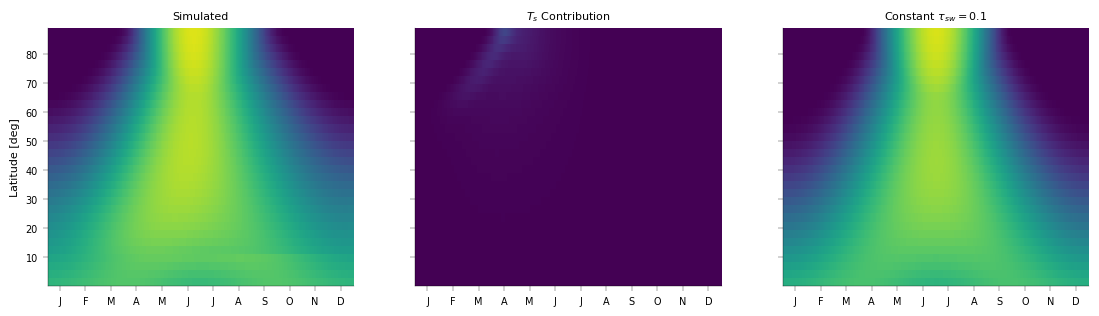

In [656]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
key = 'soc'
ax[0].pcolormesh(ds[key].dayofyear, ds[key].lat, ds['soc'].swdn_sfc.transpose(), vmin=0, vmax=300)
ax[1].pcolormesh(ds[key].dayofyear, ds[key].lat, flux_temp_only['swdn_sfc']['soc'].transpose(), vmin=0, vmax=300)
ax[2].pcolormesh(ds[key].dayofyear, ds[key].lat, get_swdn_sfc(ds['soc'].swdn_toa, albedo[key], 0.1,
                                                              ds['soc'].soc_coszen).transpose(), vmin=0, vmax=300)
ax[0].set_title('Simulated')
ax[1].set_title('$T_s$ Contribution')
ax[2].set_title('Constant $\\tau_{sw}=0.1$')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

#### Effect of albedo difference
The dotted lines below indicate if $\tau_{sw}/\mu=0.2$ at all latitudes as is the case for the gray simulation, where $\mu=\cos(\theta_z)$ is the cosine of the zenith angle, and accounts for the differing albedo. Clearly, the albedo difference alone does note account for the difference between the experiments.

$S_{sfc} = S_{TOA}e^{-\tau_{sw}/\mu}$

The surface temperature approximate optical depth formulation clearly captures the aysymmetry.

I think the difference between the blue lines is due to deviation due to time averaging stuff I have done.

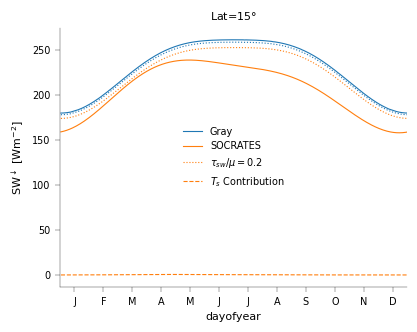

In [255]:
lat_plot_ind = 5

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for key in ['gray', 'soc']:
    ax.plot(ds[key].dayofyear, ds[key].swdn_sfc.isel(lat=lat_plot_ind), label=exp_label[key], color=color_exp[key])
    ax.plot(ds[key].dayofyear, get_swdn_sfc(ds[key].swdn_toa.isel(lat=lat_plot_ind), albedo[key], opd_sw_gray), color=color_exp[key],
            linestyle=':', label='$\\tau_{sw}/\mu=0.2$' if key=='soc' else None)
flux_temp_only['swdn_sfc']['soc'].isel(lat=lat_plot_ind).plot(color=color_exp['soc'], linestyle='--', label='$T_s$ Contribution')
ax.set_ylabel('SW$^{\downarrow}$ [Wm$^{-2}$]')
ax.legend()
ax.set_xticks(*month_ticks)
ax.set_xlim(ax_lims_time)
ax.set_title(f'Lat={ds["gray"].lat[lat_plot_ind].values:.0f}$\degree$')
plt.show()

### Temperature Tendency
We can combine our approximate estimates for the various surface heat fluxes which depend only on surface temperature, and TOA insolation, and plot the temperature tendency for various surface temperature values.

The zero crossing of this temperature tendency is thus the equilibrium temperature for that particular insolation and choice of parameters.

Land responds very quickly to changes in energy input, so it is reasonable to expect that at any given time, the surface temperature is equal to this equilibrium temperature.

So a naive estimate for the hottest day at a given latitude, would just be the equilibrium temperature with given parameters and the maximum insolation.

In [256]:
def get_temp_tendency(temp_surf, swdn_toa, albedo, opd_lw = None, opd_sw = None, coszen = None, temp_diseqb=const_params['temp_diseqb'],
                      temp_diseqb_rad=const_params['temp_diseqb_rad'],
                      rh=const_params['rh'], p_surf=const_params['ps'], wind_speed=const_params['w_atm'],
                      drag_q=const_params['drag_q'], sigma=sigma_near_surf, mixed_layer_depth=mixed_layer_depth['land'],
                      scale_height_const=scale_height_const,
                      opd_sw_empirical_amp=opd_sw_empirical_factors[1], opd_sw_empirical_power=opd_sw_empirical_factors[0],
                      lw_empirical_amp=lw_empirical_factors[1], lw_empirical_power=lw_empirical_factors[0]):
    heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
    lwup_sfc = Stefan_Boltzmann * temp_surf**4
    if opd_lw is None:
        lwdn_sfc = get_lwdn_sfc(temp_surf, temp_diseqb, scale_height_const=scale_height_const,
                                empirical_amp=lw_empirical_amp, empirical_power=lw_empirical_power)
    else:
        if coszen is not None:
            raise ValueError('With opd_lw specified, assume gray radiation so required coszen to be None')
        lwdn_sfc = get_lwdn_sfc(temp_surf, temp_diseqb, temp_diseqb_rad, opd_lw)
    lhup = get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_q, sigma, virtual=False)
    shup = get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_q, sigma, virtual=False)
    if opd_sw is None:
        opd_sw = get_opd_sw_water_approx(temp_surf, temp_diseqb, rh, scale_height_const, opd_sw_empirical_amp, opd_sw_empirical_power,
                                         p_surf, sigma)
    elif coszen is not None:
        raise ValueError('With opd_sw specified, assume gray radiation so required coszen to be None')
    swdn_sfc = get_swdn_sfc(swdn_toa, albedo, opd_sw, coszen)
    return (swdn_sfc + lwdn_sfc - lwup_sfc - lhup - shup)/heat_capacity

def get_temp_equilibrium(swdn_toa, albedo, opd_lw = None, opd_sw = None, coszen = None, temp_diseqb=const_params['temp_diseqb'],
                         temp_diseqb_rad=const_params['temp_diseqb_rad'],
                         rh=const_params['rh'], p_surf=const_params['ps'], wind_speed=const_params['w_atm'],
                         drag_q=const_params['drag_q'], sigma=sigma_near_surf, mixed_layer_depth=mixed_layer_depth['land'],
                         scale_height_const=scale_height_const,
                         opd_sw_empirical_amp=opd_sw_empirical_factors[1], opd_sw_empirical_power=opd_sw_empirical_factors[0],
                         lw_empirical_amp=lw_empirical_factors[1], lw_empirical_power=lw_empirical_factors[0], bracket=None):
    # Solve for temp tendency equals zero to get equilibrium temperature
    if bracket is None:
        bracket = [290, 330]
    var = scipy.optimize.root_scalar(get_temp_tendency, bracket=bracket, args=(swdn_toa, albedo, opd_lw, opd_sw, coszen, temp_diseqb, temp_diseqb_rad,
                                                                                rh, p_surf, wind_speed, drag_q, sigma, mixed_layer_depth,
                                                                                scale_height_const, opd_sw_empirical_amp, opd_sw_empirical_power,
                                                                                lw_empirical_amp, lw_empirical_power))
    if var.converged:
        return var.root
    else:
        raise ValueError(f'After {var.iterations}, not converged')

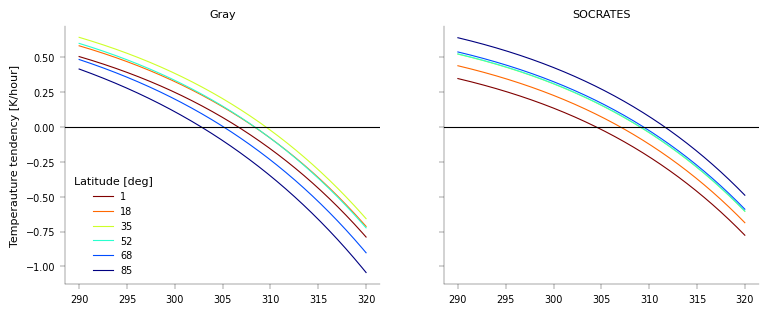

In [587]:
temp_tendency_t_surf_vals = np.linspace(290, 320, 800)
temp_surf_eqb = {key: np.zeros(ds['gray'].lat.size) for key in ['gray', 'soc', 'gray_insolation', 'soc_insolation',
                                                                'gray_param', 'soc_param']}
lat_plot_ind = np.arange(0, ds['gray'].lat.size, 6)
cmap_use = [plt.get_cmap('jet')(i) for i in np.linspace(0, 1, lat_plot_ind.size)][::-1]

ind_lat_ref = np.argmin(np.abs(ds['soc'].lat.values-50))        # use parameters at this latitude
ds_ref = {key: ds[key].isel(lat=ind_lat_ref, dayofyear=ds[key].t_surf.isel(lat=ind_lat_ref).argmax()) for key in ['gray', 'soc']}

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
j=0
for i in range(0, ds['gray'].lat.size):
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                            albedo['gray'], float(opd_lw_gray(ds['gray'].lat.isel(lat=i))), opd_sw_gray)
    temp_surf_eqb['gray'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                                                    albedo['gray'], float(opd_lw_gray(ds['gray'].lat.isel(lat=i))), opd_sw_gray,
                                                    temp_diseqb=float(ds_ref['gray'].temp_diseqb),
                            rh=float(ds_ref['gray'].rh), temp_diseqb_rad=float(ds_ref['gray'].temp_diseqb_rad_gray))
    if i in lat_plot_ind:
        ax[0].plot(temp_tendency_t_surf_vals, var*60**2, color=cmap_use[j], label=f"{ds['gray'].lat.isel(lat=i):.0f}")
    # var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['gray']['swdn_toa'].isel(lat=i).max()),
    #                         albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i).max()), rh=const_params_days['soc_hot_eq']['rh'], temp_diseqb_rad=const_params_days['soc_hot_eq']['temp_diseqb_rad'],
    #                         temp_diseqb=const_params_days['soc_hot_eq']['temp_diseqb'], drag_q=const_params_days['soc_hot_eq']['drag_q'])

    ind_use_swdn = ds['soc']['swdn_toa'].isel(lat=i).argmax()
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['soc']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                            albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)))
    if i in lat_plot_ind:
        ax[1].plot(temp_tendency_t_surf_vals, var*60**2, color=cmap_use[j])
        j += 1

    # Get estimate of temperature using actual insolation values at peak temperature time
    ind_use = ds['gray'].t_surf.isel(lat=i).argmax()
    ds_use = ds['gray'].isel(lat=i, dayofyear=ind_use)
    temp_surf_eqb['gray_insolation'][i] = get_temp_equilibrium(float(ds_use.swdn_toa),
                                                               albedo['gray'], float(opd_lw_gray(ds_use.lat)), opd_sw_gray)

    # Get estimate using actual parameter values at peak temperature time
    temp_surf_eqb['gray_param'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                            albedo['gray'], float(opd_lw_gray(ds_use.lat)), opd_sw_gray, temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_use.rh), temp_diseqb_rad=float(ds_use.temp_diseqb_rad_gray))

    ind_use = ds['soc'].t_surf.isel(lat=i).argmax()
    ds_use = ds['soc'].isel(lat=i, dayofyear=ind_use)

    temp_surf_eqb['soc'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                                                   albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)),
                                                   temp_diseqb=float(ds_ref['soc'].temp_diseqb), rh=float(ds_use.rh))
    temp_surf_eqb['soc_insolation'][i] = get_temp_equilibrium(float(ds_use.swdn_toa),
                                                              albedo['soc'], coszen=float(ds_use.soc_coszen))
    temp_surf_eqb['soc_param'][i] = get_temp_equilibrium(float(ds['soc']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                            albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)), temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_use.rh),
                            opd_sw_empirical_amp=opd_sw_empirical_factors[1])

for i, key in enumerate(['gray', 'soc']):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(0, color='k')
ax[0].legend(title='Latitude [deg]')
ax[0].set_ylabel('Temperauture tendency [K/hour]')
plt.show()

### Equilibrium Hottest Temperature
Solving the temperature tendency equals zero above gives the equilibrium temperature.

For the gray case, with reasonable choice of parameters (dashed blue line), the hottest location is in the subtropics as expected. This is due to a competition of higher insolation at the pole, and higher optical depth imposed at the equator.

For the SOCRATES simulation, the interpretation is more complicated. For the same choice of parameters, the hottest location is at the pole. This is because the pole has the most insolation, and the optical depth is now determined by the water content in the atmosphere, which is related to the surface temperature. I.e. there is a stronger feedback associated with the longwave radiation and surface temperature than in the gray case. Thus it is clear that the hottest location in this simple budget will always be where there is most insolation.

Hence, in terms of this instantaneous adjustment interpretation, for the hottest location to not be at the poles, the parameters must be important. The fact that even with parameters changing with latitude, the temperatures are systematically too high, indicates that the instantaneous interpretation is not quite correct. I.e. the hottest day at a given latitude is not that at maximum insolation, because there is a delay in how the atmosphere responds to changes at the surface etc...


#### Const params Theory
The dashed line version of the theory takes $r_a$, $T_{diseqb}$ and $T_{diseqb,r}$ to be the values at $50\degree$ on the hottest day. But the insolation, and gray longwave optical depth take their actual latitudinal value.

#### Params at max $T_s$
This version of the theory includes the latitudinal variation in the three parameters.

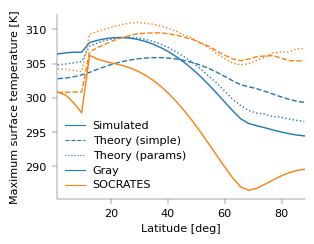

In [595]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
for key in ['gray', 'soc']:
    ax.plot(ds[key].lat, ds[key].t_surf.max(dim='dayofyear'), color=color_exp[key], label='Simulated' if key=='gray' else None)
    ax.plot(ds[key].lat, temp_surf_eqb[key], color=color_exp[key], linestyle='--', label='Theory (simple)' if key=='gray' else None)
    # plt.plot(ds[key].lat, temp_surf_eqb[key+'_insolation'], color=color_exp[key], linestyle=':')
    ax.plot(ds[key].lat, temp_surf_eqb[key+'_param'], color=color_exp[key], linestyle=':', label='Theory (params)' if key=='gray' else None)
    ax.plot(-20, 300, color=color_exp[key], label=exp_label[key])
ax.set_ylabel('Maximum surface temperature [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(ax_lims_lat)
ax.legend(ncol=1)
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
plt.show()
# isca_tools.savefig(fig, 'max_temp_lat.pdf')

### Effect of Parameters
Above we see, when we take the parameters at the time of maximum surface temperature at each latitude, then the hottest location is in subtropics, not the pole. This is despite the pole having the most insolation. Below we explore which parameters are the major factor in this. I.e. which parameters can explain why the dotted and dashed orange lines above differ.

I neglect the drag here, as I think as the wind is constant, it would make sense to impose it as a constant i.e. re-run the simulations. Also, hard to interpret. Without it, just have three parameters: insolation, relative humidity and surface - air temperature disequilibrium.

Below I plot the latitudinal variation in parameters on the hottest day at each latitude.

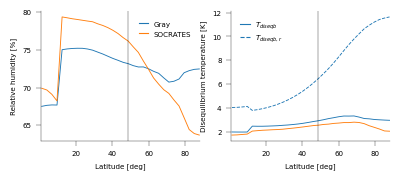

In [556]:
n_lat = ds[key].lat.size
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for key in ['gray', 'soc']:
    ax[0].plot(ds[key].lat, [ds[key].rh.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax())*100 for i in range(n_lat)], label=exp_label[key])
    ax[1].plot(ds[key].lat, [ds[key].temp_diseqb.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
               label='$T_{diseqb}$' if key=='gray' else None)
ax[1].plot(ds['gray'].lat, [ds['gray'].temp_diseqb_rad_gray.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
           color=color_exp['gray'], linestyle='--', label='$T_{diseqb,r}$')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('Disequilibrium temperature [K]')
add_legend(ax[0])
add_legend(ax[1])
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
for i in range(2):
    ax[i].axvline(ds_ref['gray'].lat, color='k', lw=ax_linewidth)
plt.show()
# isca_tools.savefig(fig, 'param_lat')

In [491]:
key = 'soc'
ind_use_swdn_ref = ds[key].swdn_toa.isel(lat=ind_lat_ref).argmax()
temp_max_ref = {key: temp_surf_eqb[key+'_param'][ind_lat_ref] for key in ['gray', 'soc']}

temp_eqb_param = {'gray': {key: np.zeros(n_lat) for key in ['swdn_toa', 'opd', 'rh', 'temp_diseqb', 'temp_diseqb_rad']},
    'soc': {key: np.zeros(n_lat) for key in ['swdn_toa', 'rh', 'temp_diseqb']}}
for i in tqdm(range(n_lat)):
    key = 'soc'
    ind_use_swdn = ds[key].swdn_toa.isel(lat=i).argmax()
    ind_use = ds[key].t_surf.isel(lat=i).argmax()
    ds_use = ds[key].isel(lat=i, dayofyear=ind_use)
    temp_eqb_param['soc']['swdn_toa'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=i, dayofyear=ind_use_swdn), albedo[key],
                                                         coszen=ds[key].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn),
                                                         rh=ds_ref['soc'].rh, temp_diseqb=ds_ref['soc'].temp_diseqb)
    temp_eqb_param['soc']['rh'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), albedo[key],
                                                   coszen=ds[key].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), rh=ds_use.rh,
                                                   temp_diseqb=ds_ref['soc'].temp_diseqb)
    temp_eqb_param['soc']['temp_diseqb'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), albedo[key],
                                                         coszen=ds[key].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref),
                                                         temp_diseqb=ds_use.temp_diseqb, rh=ds_ref['soc'].rh)

    key = 'gray'
    ind_use = ds[key].t_surf.isel(lat=i).argmax()
    ds_use = ds[key].isel(lat=i, dayofyear=ind_use)
    temp_eqb_param[key]['swdn_toa'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=i).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['opd'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_use.lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['rh'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_use.rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['temp_diseqb'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['temp_diseqb_rad'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_use.temp_diseqb_rad_gray))

for key2 in ['soc', 'gray']:
    temp_eqb_param[key2]['sum'] = sum([temp_eqb_param[key2][key]-temp_max_ref[key2] for key in temp_eqb_param[key2]]) + temp_max_ref[key2]
    temp_eqb_param[key2]['non_linear'] = temp_surf_eqb[f'{key2}_param'] - temp_eqb_param[key2]['sum'] + temp_max_ref[key2]

  0%|          | 0/32 [00:00<?, ?it/s]

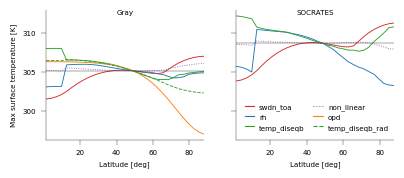

In [594]:
colors_use = {'rh': default_colors[0], 'swdn_toa': default_colors[3], 'temp_diseqb': default_colors[2], 'non_linear': default_colors[4],
              'opd': default_colors[1], 'temp_diseqb_rad': default_colors[2]}
linestyle_use = {key: None for key in colors_use}
linestyle_use['temp_diseqb_rad'] = '--'
linestyle_use['non_linear'] = ':'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for i, key2 in enumerate(['gray', 'soc']):
    ax[i].set_title(exp_label[key2], y=0.9)
    for key in ['swdn_toa', 'rh', 'temp_diseqb', 'non_linear', 'opd', 'temp_diseqb_rad']:
        if key not in temp_eqb_param[key2]:
            ax[i].plot(-100, 300, color=colors_use[key], linestyle=linestyle_use[key], label=key)
        else:
            ax[i].plot(ds[key2].lat, temp_eqb_param[key2][key], label=key, color=colors_use[key], linestyle=linestyle_use[key])
    # if key2 == 'gray':
    #     for key in ['opd', 'temp_diseqb_rad']:
    #         ax[i].plot(ds[key2].lat, temp_eqb_param[key2][key], label=key, color=colors_use[key], linestyle='--' if key=='temp_diseqb_rad' else None)
    # ax[i].plot(ds[key2].lat, temp_surf_eqb[f'{key2}_param'], color='k', label='sum')
#ax[0].legend(ncol=2)
# ax[0].plot(ds[key2].lat, temp_eqb_param['gray']['swdn_toa'] + temp_eqb_param['gray']['opd'] - temp_max_ref['gray'], color='k', linestyle=':')
# ax[1].plot(ds[key2].lat, temp_eqb_param['soc']['swdn_toa'] + temp_eqb_param['soc']['rh'] - temp_max_ref['soc'], color='k', linestyle=':')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Max surface temperature [K]')
ax[0].set_xlim(ax_lims_lat)
add_legend(ax[1], ncol=2)
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
for i, key2 in enumerate(['gray', 'soc']):
    ax[i].axhline(temp_max_ref[key2], color='k', lw=ax_linewidth)
plt.show()
# isca_tools.savefig(fig, 'temp_max_param')

In [567]:
n_rh_2d_plot = 21
rh_2d_plot = np.linspace(0.5, 1.0, n_rh_2d_plot)
opd_2d_plot = np.linspace(0, 6, n_rh_2d_plot)
temp_eqb_2d = {'soc_rh': np.zeros((n_lat, n_rh_2d_plot)), 'gray_opd_pole': np.zeros((n_lat, n_rh_2d_plot))}
pbar = tqdm(total=n_rh_2d_plot*n_lat)
for i in range(n_lat):
    ind_use_swdn = ds['soc'].swdn_toa.isel(lat=i).argmax()
    for j in range(n_rh_2d_plot):
       temp_eqb_2d['soc_rh'][i,j] = get_temp_equilibrium(ds['soc'].swdn_toa.isel(lat=i, dayofyear=ind_use_swdn), albedo['soc'],
                            coszen=ds['soc'].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn),
                            temp_diseqb=ds_ref['soc'].temp_diseqb, rh=rh_2d_plot[j], bracket=[280, 340])
       temp_eqb_2d['gray_opd_pole'][i,j] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                                                                albedo['gray'], opd_2d_plot[j], opd_sw_gray,
                                                                bracket=[220, 350], rh=ds_ref['gray'].rh, temp_diseqb=ds_ref['gray'].temp_diseqb,
                                                                temp_diseqb_rad=ds_ref['gray'].temp_diseqb_rad_gray)
       pbar.update(1)

  0%|          | 0/672 [00:00<?, ?it/s]

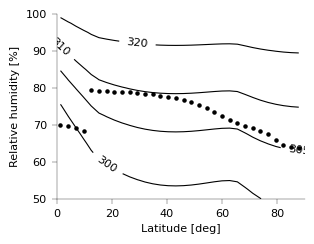

In [651]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, rh_2d_plot*100, temp_eqb_2d['soc_rh'].transpose(), colors='black', levels=[300, 305, 310, 320])
ax.set_xlim(0, 90)
ax.clabel(var_plot, inline=True)
isca_tools.plot.update_fontsize(fig)
ax.scatter(ds['soc'].lat, [float(ds['soc'].rh.isel(lat=i, dayofyear=ds['soc'].t_surf.isel(lat=i).argmax()))*100 for i in range(n_lat)],
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Relative humidity [%]')
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'soc_rh_lat.pdf')

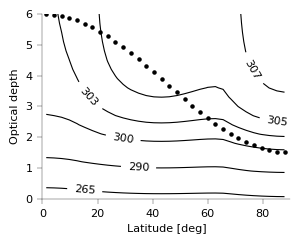

In [648]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, opd_2d_plot, temp_eqb_2d['gray_opd_pole'].transpose(), levels=[265, 290, 300, 303, 305, 307], colors='black')
ax.clabel(var_plot, inline=True)
ax.scatter(ds['soc'].lat, opd_lw_gray(ds['soc'].lat),
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Optical depth')
ax.set_xlim(0, 90)
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'gray_opd_lat.pdf')

In [582]:
ds['gray'].lat[9]

<xarray.DataArray 'lat' ()> Size: 8B
array(26.51076933)
Coordinates:
    lat      float64 8B 26.51
Attributes:
    long_name:       latitude
    units:           degrees_N
    cartesian_axis:  Y
    edges:           latb